# Confirm the ideal location to open New restaurant

In [1]:
#importing required libraries

import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import requests

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans


import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
import xml


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response= requests.get(url).text
soup= BeautifulSoup(response,'html.parser')
postcode_tables= soup.find('table')
table_columns= postcode_tables.find_all('td')

In [3]:
postcode=[]
borough=[]
neighborhood=[]

for x in range(0,len(table_columns),3):
    postcode.append(table_columns[x].text.strip())
    borough.append(table_columns[x+1].text.strip())
    neighborhood.append(table_columns[x+2].text.strip())

df= pd.DataFrame(list(zip(postcode,borough,neighborhood)),columns=['Postcode','Borough','Neighborhood'])
df.shape


(287, 3)

In [4]:
# keeping only Borough cells with values, removing missing ones.
df['Borough'].replace('Not assigned',np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)
df.shape

(210, 3)

In [5]:
# Put neighborhoods in one row separated by comma

df= df.groupby(['Postcode','Borough'])['Neighborhood'].apply(' ,'.join).reset_index()
df.shape


(103, 3)

In [6]:
# Cells with "Not assigned" will be renamed to "Queen's park"
df['Neighborhood'].replace('Not assigned','Queen\'s park',inplace=True)

In [7]:
#Parsinf geo location data
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.rename(columns={'Postal Code':'Postcode'}, inplace=True)
df_geo.head()


,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
# merging two dataframes based on key "Postcode"
df_toronto = df.join(df_geo.set_index('Postcode'), on='Postcode')
df_toronto = df_toronto[df_toronto['Borough'].str.contains('Toronto')]

In [9]:
df_toronto.shape
df_toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West ,Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West ,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [10]:
address = 'Toronto , CA'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [11]:


# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [12]:
!conda install -c conda-forge wikipedia --yes 

import wikipedia as wp

#overall population distribution 
html = wp.page("Demographics of Toronto").html().encode("UTF-8")


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wikipedia


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wikipedia-1.4.0            |             py_2          13 KB  conda-forge

The following NEW packages will be INSTALLED:

    wikipedia: 1.4.0-py_2 conda-forge


wikipedia-1.4.0      | 13 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [13]:
CLIENT_ID = 'XSK5FU0ZCWISTIMZD3N41YAPCD24G2MUIS0ULHYGR4P3N2B1' # your Foursquare ID
CLIENT_SECRET = 'WELWQUTS2IQ4EH3KAJ3YSWBKYBN0MRFNIT5O5M30XQPYYGUA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XSK5FU0ZCWISTIMZD3N41YAPCD24G2MUIS0ULHYGR4P3N2B1
CLIENT_SECRET:WELWQUTS2IQ4EH3KAJ3YSWBKYBN0MRFNIT5O5M30XQPYYGUA


### Explore and cluster the neighborhoods in Toronto

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    

In [16]:
LIMIT = 1000
radius = 500
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )


print(toronto_venues.shape)
toronto_venues.head()

The Beaches
The Danforth West ,Riverdale
The Beaches West ,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park ,Summerhill East
Deer Park ,Forest Hill SE ,Rathnelly ,South Hill ,Summerhill West
Rosedale
Cabbagetown ,St. James Town
Church and Wellesley
Harbourfront
Ryerson ,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide ,King ,Richmond
Harbourfront East ,Toronto Islands ,Union Station
Design Exchange ,Toronto Dominion Centre
Commerce Court ,Victoria Hotel
Roselawn
Forest Hill North ,Forest Hill West
The Annex ,North Midtown ,Yorkville
Harbord ,University of Toronto
Chinatown ,Grange Park ,Kensington Market
CN Tower ,Bathurst Quay ,Island airport ,Harbourfront West ,King and Spadina ,Railway Lands ,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place ,Underground city
Christie
Dovercourt Village ,Dufferin
Little Portugal ,Trinity
Brockton ,Exhibition Place ,Parkdale Village
High Park ,The Junction Sout

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
2,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
3,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [17]:
#toronto_venues.groupby('Neighborhood').count()
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 unique categories.


In [18]:
# one hot encoding
tor_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
toronto_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide ,King ,Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.00000,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.01
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton ,Exhibition Place ,Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower ,Bathurst Quay ,Island airport ,Harbo...",0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.071429,0.071429,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown ,St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,...,0.00000,0.000000,0.00000,0.00,0.012195,0.000000,0.000000,0.012195,0.000000,0.00
7,"Chinatown ,Grange Park ,Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.035294,0.000000,0.047059,0.011765,0.000000,0.00
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011905,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.011905,0.000000,0.011905,0.00


In [20]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide ,King ,Richmond----
             venue  freq
0      Coffee Shop  0.06
1       Restaurant  0.04
2  Thai Restaurant  0.04
3             Café  0.04
4              Bar  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1              Bakery  0.04
2        Cocktail Bar  0.04
3  Seafood Restaurant  0.04
4         Cheese Shop  0.04


----Brockton ,Exhibition Place ,Parkdale Village----
            venue  freq
0            Café  0.14
1     Coffee Shop  0.09
2  Breakfast Spot  0.09
3             Gym  0.05
4   Burrito Place  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Light Rail Station  0.11
1                Garden  0.06
2         Auto Workshop  0.06
3  Fast Food Restaurant  0.06
4            Skate Park  0.06


----CN Tower ,Bathurst Quay ,Island airport ,Harbourfront West ,King and Spadina ,Railway Lands ,South Niagara----
              venue  freq
0    Airport Lounge  0.14
1  Sculpture Garden

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [23]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide ,King ,Richmond",Coffee Shop,Restaurant,Café,Bar,Thai Restaurant,Cosmetics Shop,Steakhouse,Sushi Restaurant,Asian Restaurant,Breakfast Spot
1,Berczy Park,Coffee Shop,Seafood Restaurant,Restaurant,Cheese Shop,Farmers Market,Beer Bar,Bakery,Cocktail Bar,Café,Gourmet Shop
2,"Brockton ,Exhibition Place ,Parkdale Village",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Pizza Place,Fast Food Restaurant,Farmers Market,Burrito Place,Auto Workshop,Spa,Moving Target,Restaurant,Brewery
4,"CN Tower ,Bathurst Quay ,Island airport ,Harbo...",Airport Lounge,Boutique,Airport Terminal,Rental Car Location,Coffee Shop,Boat or Ferry,Harbor / Marina,Bar,Airport Service,Airport Gate


## Relationship between neighborhood and Chinese Restaurant

In [24]:
toronto_part = toronto_grouped[['Neighborhood', 'Chinese Restaurant']]
toronto_part

,Neighborhood,Chinese Restaurant
0,"Adelaide ,King ,Richmond",0.000000
1,Berczy Park,0.000000
2,"Brockton ,Exhibition Place ,Parkdale Village",0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000
4,"CN Tower ,Bathurst Quay ,Island airport ,Harbo...",0.000000
5,"Cabbagetown ,St. James Town",0.020833
6,Central Bay Street,0.024390
7,"Chinatown ,Grange Park ,Kensington Market",0.047059
8,Christie,0.000000
9,Church and Wellesley,0.011905


In [26]:
toronto_merged = pd.merge(df_toronto, toronto_part, on='Neighborhood')
toronto_merged

,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.000000
1,M4K,East Toronto,"The Danforth West ,Riverdale",43.679557,-79.352188,0.000000
2,M4L,East Toronto,"The Beaches West ,India Bazaar",43.668999,-79.315572,0.000000
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0.000000
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0.000000
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0.000000
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0.047619
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,0.000000
8,M4T,Central Toronto,"Moore Park ,Summerhill East",43.689574,-79.383160,0.000000
9,M4V,Central Toronto,"Deer Park ,Forest Hill SE ,Rathnelly ,South Hi...",43.686412,-79.400049,0.000000


<Figure size 1368x1440 with 0 Axes>

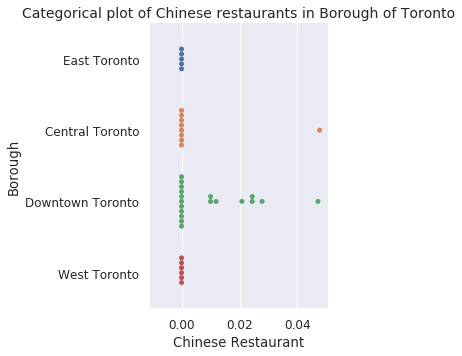

In [35]:
# Let's try Categorical plot 

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(19,20))

sns.set(font_scale=1.1)
sns.catplot(x="Chinese Restaurant", y="Borough",kind ="swarm" ,data=toronto_merged);

plt.title('Categorical plot of Chinese restaurants in Borough of Toronto', fontsize=14)
plt.show()

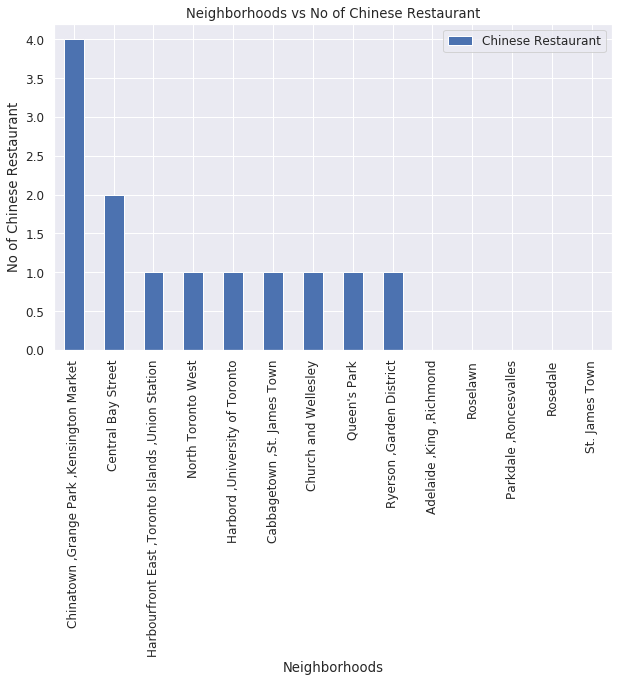

In [37]:
graph = pd.DataFrame(tor_onehot.groupby('Neighborhood')['Chinese Restaurant'].sum())
graph = graph.sort_values(by ='Chinese Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Chinese Restaurant")
plt.title("Neighborhoods vs No of Chinese Restaurant")
plt.show()


In [38]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[13]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[14]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [40]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[15]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:


#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[16]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df



,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#Merge all the population table with the ethnic percentage by neighborhood
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                               'Ethnic Origin #9','Ethnic Origin 9 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.00,Filipino,7.8,NaN,NaN,NaN,NaN
7,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.00,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.20,Chinese,7.2,NaN,NaN,NaN,NaN
9,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above dataframe we can pickout the neighborhoods with highest Indian population percentage by using the below given method. 

In [44]:
#Filtering the riding with Chinese ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'Chinese')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'Chinese')]
chinese_df = pd.DataFrame(temp).reset_index()
chinese_df.drop('index',axis=1,inplace=True)

chinese_df.head()


,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN,NaN,NaN
4,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#retaining only Chinese ethnic percentage & the neighborhood name 
columns_list = pop_indian_df.columns.to_list()
pop_chinese_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,chinese_df.shape[0]):
    for j in columns_list:
        print(j)
        if chinese_df.at[i, j] == 'Chinese':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_chinese_DF_with_percent = pop_chinese_DF_with_percent.append({'Riding':chinese_df.at[i, 'Riding'], 'Population':chinese_df.at[i, 'Population']
                                                                           , 'Ethnicity': chinese_df.at[i, j], 'Percentage': chinese_df.at[i, percent_col]},ignore_index=True)

pop_chinese_DF_with_percent      

Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origi

,Ethnicity,Percentage,Population,Riding
0,Chinese,25.9,117405.0,Willowdale
1,Chinese,32.4,109060.0,Don Valley North
2,Chinese,11.2,101790.0,Don Valley West
3,Chinese,8.9,93170.0,Don Valley East
4,Chinese,10.7,110450.0,Scarborough Centre
5,Chinese,7.2,108295.0,Scarborough Southwest
6,Chinese,47.0,104225.0,Scarborough-Agincourt
7,Chinese,7.1,101115.0,Scarborough-Guildwood
8,Chinese,46.6,97610.0,Scarborough North
9,Chinese,16.0,114315.0,Spadina-Fort York


In [46]:
pop_chinese_DF_with_percent['Chinese Population'] = (pop_chinese_DF_with_percent['Percentage'] * pop_chinese_DF_with_percent['Population'])/100
pop_chinese_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_chinese_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_chinese_DF_with_percent

,Riding,Chinese Population
0,Willowdale,30407.895
1,Don Valley North,35335.440
2,Don Valley West,11400.480
3,Don Valley East,8292.130
4,Scarborough Centre,11818.150
5,Scarborough Southwest,7797.240
6,Scarborough-Agincourt,48985.750
7,Scarborough-Guildwood,7179.165
8,Scarborough North,45486.260
9,Spadina-Fort York,18290.400


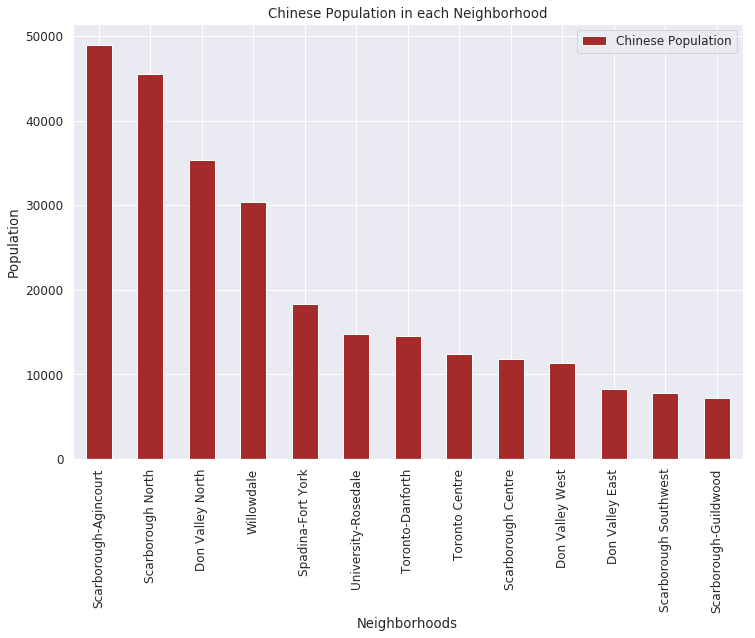

In [47]:
bar_graph = pop_chinese_DF_with_percent.sort_values(by='Chinese Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Chinese Population',figsize=(12,8), color='brown')
plt.title("Chinese Population in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

### Relationship between Indian poplation and Indian restaurant

<h2>4. Predictive Modeling</h2>


<h3>4.1 Clustering Neighborhoods of Toronto:</h3>


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


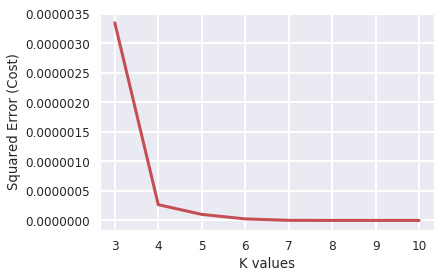

In [51]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

###### After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 4 is the best value.

<h4> Clustering the Toronto Neighborhood Using K-Means with K = 4 </h4>

In [56]:
kclusters = 4

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([0, 0, 0, 0, 0, 1, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0,
       0, 0, 0, 2, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [60]:
toronto_part.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df_toronto
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.0
1,M4K,East Toronto,"The Danforth West ,Riverdale",43.679557,-79.352188,0,0.0
2,M4L,East Toronto,"The Beaches West ,India Bazaar",43.668999,-79.315572,0,0.0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,0.0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0.0


Let us see the clusters visually on the map with the help of Folium.

In [61]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

<h3>4.2 Examing the Clusters:</h3>


We have total of 4 clusters such as 0,1,2,3. Let us examine one after the other.



Cluster 0 contains all the neighborhoods which has least number of Indian restaurants. It is shown in red color in the map

In [62]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.0
1,M4K,East Toronto,"The Danforth West ,Riverdale",43.679557,-79.352188,0,0.0
2,M4L,East Toronto,"The Beaches West ,India Bazaar",43.668999,-79.315572,0,0.0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,0.0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0.0
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0,0.0
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,0.0
8,M4T,Central Toronto,"Moore Park ,Summerhill East",43.689574,-79.383160,0,0.0
9,M4V,Central Toronto,"Deer Park ,Forest Hill SE ,Rathnelly ,South Hi...",43.686412,-79.400049,0,0.0
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,0.0


Cluster 1 contains the neighborhoods which is sparsely populated with Indian restaurants. It is shown in purple color in the map.

In [63]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
11,M4X,Downtown Toronto,"Cabbagetown ,St. James Town",43.667967,-79.367675,1,0.020833
17,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,0.024390
25,M5S,Downtown Toronto,"Harbord ,University of Toronto",43.662696,-79.400049,1,0.027778
37,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,1,0.024390


Cluster 2 has no rows meaning no data points or neighborhood was near to this centroid.

In [64]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,2,0.047619
26,M5T,Downtown Toronto,"Chinatown ,Grange Park ,Kensington Market",43.653206,-79.400049,2,0.047059


Cluster 3 contains all the neighborhoods which is medium populated with Indian restaurants. It is shown in blue color in the map.

In [65]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
12,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3,0.011905
14,M5B,Downtown Toronto,"Ryerson ,Garden District",43.657162,-79.378937,3,0.010000
19,M5J,Downtown Toronto,"Harbourfront East ,Toronto Islands ,Union Station",43.640816,-79.381752,3,0.010000
